In [1]:
import os
import random
import time
import glob
import json
import dit
import itertools
import time
from datetime import datetime
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from functools import partial
os.chdir("../")
from helpers.group_helpers import classify_syms, srv_to_mat
from helpers.compare_helpers import appendtoPXS,load_frame,addbestsym
from jointpdfpython3.measures import synergistic_entropy_upper_bound, append_random_srv
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")
import seaborn as sns;sns.set()

## Convergence of scipy minimize (jointpdf)

In [6]:
from scipy.optimize import minimize

class OpObj(object):
    def __init__(self, jXS,subjects,sid):
        self.jXS = jXS
        self.subjects=subjects
        self.sid=sid
        self.f = np.full(shape=(500,), fill_value=np.NaN)
        self.count = 0
    def _fun(self):
        totmi = self.jXS.mutual_information(self.subjects,[self.sid])
        indivmis = sum([self.jXS.mutual_information([i],[self.sid]) for i in self.subjects])        
        return totmi-indivmis
#         return self.jXS.synergistic_information_naive()
    
def cb(xk, obj=None):
    obj.f[obj.count] = obj._fun()
    obj.count += 1

def costf(srvparams,jXS,lenJXS,parX,subjects,upper):
    params2matrix_incremental(jXS,parX+list(srvparams))
    totmi = jXS.mutual_information(subjects,[lenJXS-1])
    indivmis = sum([jXS.mutual_information([i],[lenJXS-1]) for i in subjects])
    cost=abs((upper-(totmi-indivmis))/upper)
    if totmi != 0:
        return cost+((indivmis/totmi))
    else:
        return cost+(indivmis)

minimize_options = {'ftol': 1e-6}
def symsyninfo(states,lenX,jX,syms,initialtype='first',costf=costf):
    subjects = list(range(lenX))
    parX = matrix2params_incremental(jX)
    upper = synergistic_entropy_upper_bound(jX)
    jXS = append_random_srv(jX,parX,1)
    lenJXS = len(jXS)
    bestsymid=-1
    # get initial guess of best sym
    if initialtype!='random':
        if initialtype=='first':
            syms=[syms[0]]
        pXSym,bestsymid = addbestsym(lenX,jX,upper,syms)
        jXS.joint_probabilities.joint_probabilities = pXSym

    freeparams = (states**(lenJXS))-(states**(len(jX)))
    symparams = matrix2params_incremental(jXS)[-freeparams:]
    subjects = np.arange(lenX)
    op_obj = OpObj(jXS,subjects,lenJXS-1)
    optres_ix = minimize(costf,
                            symparams,
                            bounds=[(0.0, 1.0)]*freeparams,
                            callback=partial(cb,obj=op_obj),
                            args=(jXS,lenJXS,parX,subjects,upper),options=minimize_options)
    params2matrix_incremental(jXS,parX+list(optres_ix.x))
    return bestsymid,jXS, op_obj

## WMS value for increasing repeats (jointpdf)

In [15]:
x=np.linspace(1,500,500)
states = 4
lenX = 2
subjects = np.arange(lenX)
t='random'
cursyms = []
data = {'systemID':[],'repeats':[],'WMS(X;S)':[],'upper':[],'difference WMS':[],'Golden Mean':[],'difference GM':[]}
samples = 25
repeats = 7
for sys in range(samples):
    print("SYS ID",sys,datetime.fromtimestamp(time.time()))
    jXS = JointProbabilityMatrix(lenX+1,states)
    lenJXS = len(jXS)
    upper = synergistic_entropy_upper_bound(jXS[subjects])
    parXS = matrix2params_incremental(jXS)
    parX = parXS[:(states**lenX)-1]
    freeparams = len(parXS[(states**lenX)-1:])
    bestWMS = 0
    bestGM = 0
    for test in range(1,repeats+1):
        opts = []
        costs = []
        for _ in range(test):
            parS = np.random.random(freeparams)
            optres_ix = minimize(costf,
                                    parS,
                                    bounds=[(0.0, 1.0)]*freeparams,
                                    args=(jXS,lenJXS,parX,subjects,upper),options=minimize_options)
            opts.append(optres_ix.x)
            costs.append(optres_ix.fun)
        opt = opts[costs.index(min(costs))]
        params2matrix_incremental(jXS,parX+list(opt))
        totmi = jXS.mutual_information(subjects,[lenJXS-1])
        indivmis = [jXS.mutual_information([i],[lenJXS-1]) for i in subjects]
        data['systemID'].append(sys)
        data['repeats'].append(test)
        data['WMS(X;S)'].append(totmi-sum(indivmis))
        data['Golden Mean'].append(((totmi-sum(indivmis))+(totmi-max(indivmis)))/2)
        data['upper'].append(upper)
        
        if test == 1:
            bestWMS = data['WMS(X;S)'][-1]
            bestGM = data['Golden Mean'][-1]
            data['difference WMS'].append(0)
            data['difference GM'].append(0)
        else:
            data['difference WMS'].append(data['WMS(X;S)'][-1]-bestWMS)
            data['difference GM'].append(data['Golden Mean'][-1]-bestGM)
            if data['WMS(X;S)'][-1] > bestWMS:
                bestWMS=data['WMS(X;S)'][-1]
            if data['Golden Mean'][-1] > bestGM:
                bestGM=data['Golden Mean'][-1]

df = pd.DataFrame(data=data)

SYS ID 0 2022-05-11 17:04:22.015455


C:\Users\enrik\Desktop\Mabomba\Studie\MasterCS\Thesis\code\jointpdfpython3\JointProbabilityMatrix.py:527: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item == 'all':


SYS ID 1 2022-05-11 17:32:18.235244
SYS ID 2 2022-05-11 17:52:54.305613
SYS ID 3 2022-05-11 18:11:03.375771
SYS ID 4 2022-05-11 18:28:06.836029
SYS ID 5 2022-05-11 18:49:06.086454
SYS ID 6 2022-05-11 19:12:39.217316
SYS ID 7 2022-05-11 19:38:29.409711
SYS ID 8 2022-05-11 20:02:25.596147
SYS ID 9 2022-05-11 20:19:33.671955
SYS ID 10 2022-05-11 20:42:28.160703
SYS ID 11 2022-05-11 21:04:29.261872
SYS ID 12 2022-05-11 21:26:03.363451
SYS ID 13 2022-05-11 21:46:25.203796
SYS ID 14 2022-05-11 22:09:51.546072
SYS ID 15 2022-05-11 22:27:04.916447
SYS ID 16 2022-05-11 22:46:50.808530
SYS ID 17 2022-05-11 23:07:47.792146
SYS ID 18 2022-05-11 23:28:17.572679
SYS ID 19 2022-05-11 23:47:11.792420
SYS ID 20 2022-05-12 00:08:04.463217
SYS ID 21 2022-05-12 00:25:18.243999
SYS ID 22 2022-05-12 00:40:24.792305
SYS ID 23 2022-05-12 00:56:57.628247
SYS ID 24 2022-05-12 01:10:48.927817


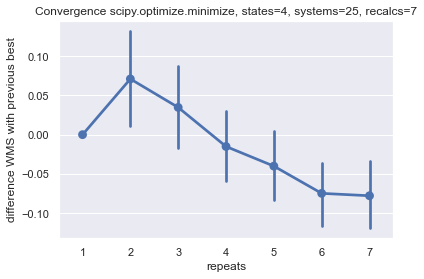

In [5]:
# df.to_pickle("../../results/test/optimalityjointpdfstates"+str(states)+".pkl")
states=4
samples=25
repeats=7
df = pd.read_pickle("../../results/test/optimalityjointpdfstates"+str(states)+".pkl")
fig, ax = plt.subplots(1,1)
ax=sns.pointplot(data=df,x='repeats',y='difference WMS')
plt.ylabel("difference WMS with previous best")
plt.title("Convergence scipy.optimize.minimize, states="+str(states)+", systems="+str(samples)+", recalcs="+str(repeats))
plt.show()

## Convergence of difference in WMS (jointpdf)

In [30]:
# x=np.linspace(1,500,500)
# states = 4
# lenX = 2
# t='random'
# cursyms = []
# data = {'systemID':[],'step':[],'WMS(X;S)':[],'difference':[]}
# samples = 15
# repeats = 20
# for sys in range(samples):
#     print(sys,datetime.fromtimestamp(time.time()))
#     jX = JointProbabilityMatrix(lenX,states)
#     for test in range(repeats):
#         best, jXS,op_obj = symsyninfo(states,lenX,jX,\
#                        cursyms,initialtype=t,costf=costfunc)
#         a = list(op_obj.f[~np.isnan(op_obj.f)])
#         data['systemID'].append([sys for _ in range(len(a))])
#         data['step'].append(np.arange(len(a)))
#         data['WMS(X;S)'].append(a)
#         x=np.arange(0,len(a))
#         a = [0]+list(np.diff(a))
#         data['difference'].append(a)

# df = pd.DataFrame(data=data)
# df=df.apply(pd.Series.explode).reset_index()
# # df.to_pickle("../../results/test/optimalityjointpdfstates"+str(states)+"-2.pkl") 

## Save load plot

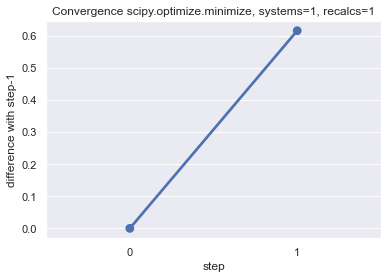

In [33]:
df = pd.DataFrame(data=data)
df=df.apply(pd.Series.explode).reset_index()
df.to_pickle("../../results/test/optimalityscipystates"+str(states)+".pkl") 

fig, ax = plt.subplots(1,1)
# ax=sns.pointplot(data=df,x='step',y='WMS(X;S)',hue='systemID')
ax=sns.pointplot(data=df,x='step',y='difference')
# ax2 = plt.twinx()
# sns.pointplot(data=df,x='step',y='difference',hue='systemID',ci='sd',palette=['red'],ax=ax2)
plt.title("Convergence scipy.optimize.minimize,states="+str(states)+" ,systems="+\
          str(samples)+", recalcs="+str(repeats))
plt.show()

## Compute X multiple increasing times (syndisc)

0 12:29:04
1 12:29:04
2 12:29:05
3 12:29:05
4 12:29:05
5 12:29:05


Text(0.5, 1.0, 'Convergence to syn info (syndisc)')

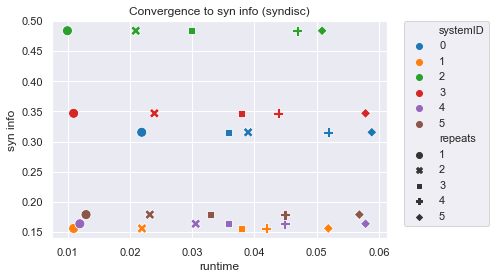

In [29]:
data = {'systemID':[],'parX':[],'upper':[],'syn info':[],'runtime':[],'repeats':[]}
meansize = np.arange(5)+1
samples=6
for i in range(samples):
    print(i,time.strftime("%H:%M:%S", time.localtime()))
    jX = JointProbabilityMatrix(lenX,states)
    upper = synergistic_entropy_upper_bound(jX)
    pX = jX.joint_probabilities.joint_probabilities
    parX = matrix2params_incremental(jX)
    for m in meansize:
        totruntime = 0
        tottotmi = 0
        totindivmi = 0
        for _ in range(m):
            ditjX = dit.Distribution.from_ndarray(pX)
            try:                
                before = time.time()
                syn, probs = self_disclosure_channel(ditjX)
                totruntime+=time.time()-before
                tottotmi+=syn
            except:
                print("Error occured",i)            
        data['runtime'].append(totruntime)
        data['syn info'].append(tottotmi/m)  
        data['repeats'].append(m)
        data['systemID'].append(i)
        data['upper'].append(upper)
        data['parX'].append(parX)

hue='systemID'
initialdata = pd.DataFrame(data=data)
initialdata.to_pickle("../../results/test/optimalitysyndisc"+str(states)+"-"+str(i)+".pkl") 
sns.scatterplot(data=initialdata,x='runtime',y='syn info',style='repeats',s=100,hue=hue,palette='tab10')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.01)
plt.title("Convergence to syn info (syndisc)")